# 3D color printing a dust disk

In [1]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap

from tqdm.auto import tqdm

import astro3d
from astro3d.image_stack import makeslice
from astro3d.image_stack import VeroC_sRGB
from astro3d.image_stack import VeroM_sRGB
from astro3d.image_stack import VeroY_sRGB

plt.style.use([{'image.cmap':'gray_r'}])

## Setup

### Read data

In [2]:
with np.load(astro3d.get_data('pluto_data_norm.npz')) as f:
    data = f['rho']
    x = f['x']
    y = f['y']
    z = f['z']

### Printer settings

printer specific and layer thickness can be chosen to be different)

In [3]:
# these are the values used in alphacams TEILEFABRIK, where we ordered some of our prints
dpi_x = 600
dpi_y = 300
dpi_z = 940 # 0.027 mm layer thickness = 2.54 / dpi_z

Choose the height of the print, the rest should rescale accordingly

In [4]:
height = 2 # this should be the total height of the printed cube in cm

### Output folder

We store the images in the path set by `path`.

In [5]:
path = Path(astro3d.get_output()) / 'slices_pluto_color3_doc'

In [6]:
if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

directory exists, deleting old files


### New coordinates

calculate the new grids in x, y, z

In [7]:
#n_z = int(height / layer_thickness)
n_z = int(height * dpi_z / 2.54)

n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x%2 # add 1 to make it even if it isn't
n_y += n_y%2 # add 1 to make it even if it isn't

x2 = np.linspace(x[0], x[-1], n_x)
y2 = np.linspace(y[0], y[-1], n_y)
z2 = np.linspace(z[0], z[-1], n_z)

create an interpolation function for the non-normalized 3D data

In [8]:
def f_interp(coords):
    return astro3d._fortran.fmodule.interpolate(x, y, z, data, coords)

set the coordinates-tuple which is passed to the interpolation. x and y entries will stay the same and only the z entry will change.

Note that `coords` will not be passed to the interpolation function in this form, but will be transformed to a shape `(N, 3)`, where the number of points `N = len(x2) * len(y2)`.

In [9]:
coords = (x2, y2, z2)

### Normalization & color choices

Find the largest magnitude of the data values and define a logarithmic norm

In [10]:
dyn_range = 1e-4
vmax = data.max()
norm = LogNorm(dyn_range * vmax, vmax, clip=True)

define the density levels, their width, their colors, and the filling factors of the colors

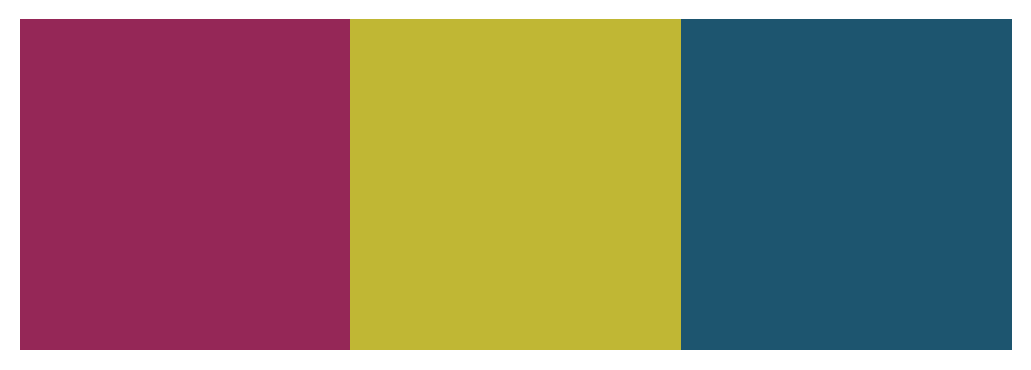

In [11]:
levels = np.array([0.15, 0.65, 0.92])
sigmas = np.array([0.02, 0.05, 0.06])
fill = np.array([0.2, 0.06, 0.3])
clip = np.array([3.0, 3.0, 3.0])

colors = [VeroM_sRGB, VeroY_sRGB, VeroC_sRGB]

plt.imshow([colors]).axes.axis('off');

Show a histogram of the data values

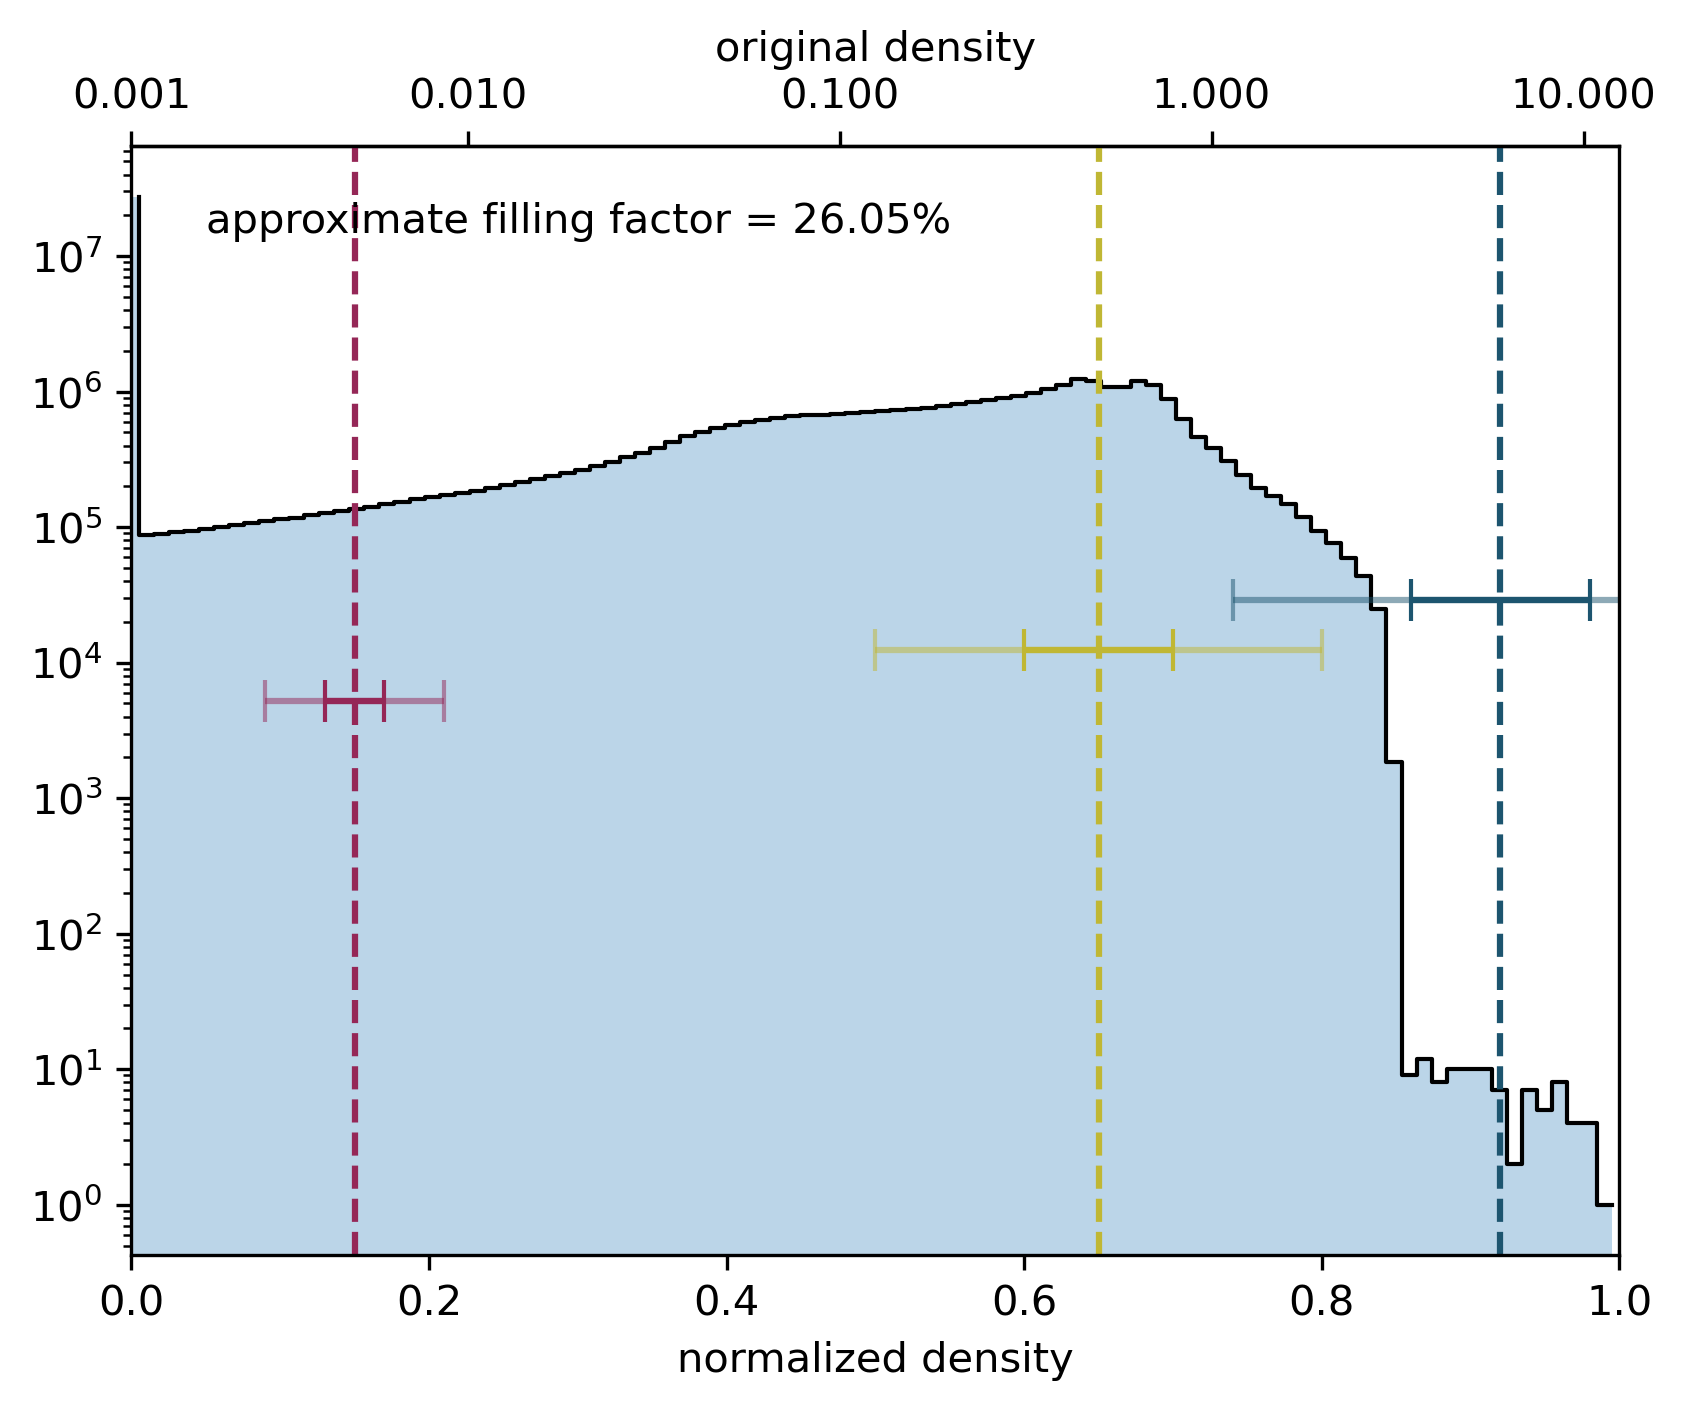

In [12]:
astro3d.image_stack.show_histogram(data, norm, colors, levels, sigmas, clip)

## Example slice

select which index in the new z-grid to process

In [13]:
iz = int(np.ceil(n_z / 2))

Process one slice and check the results

In [14]:
layer_dithered = makeslice(iz, z2, f_interp, coords, norm, path,
                levels=levels, sigmas=sigmas, fill=fill,
                colors=colors, f=np.ones(3))

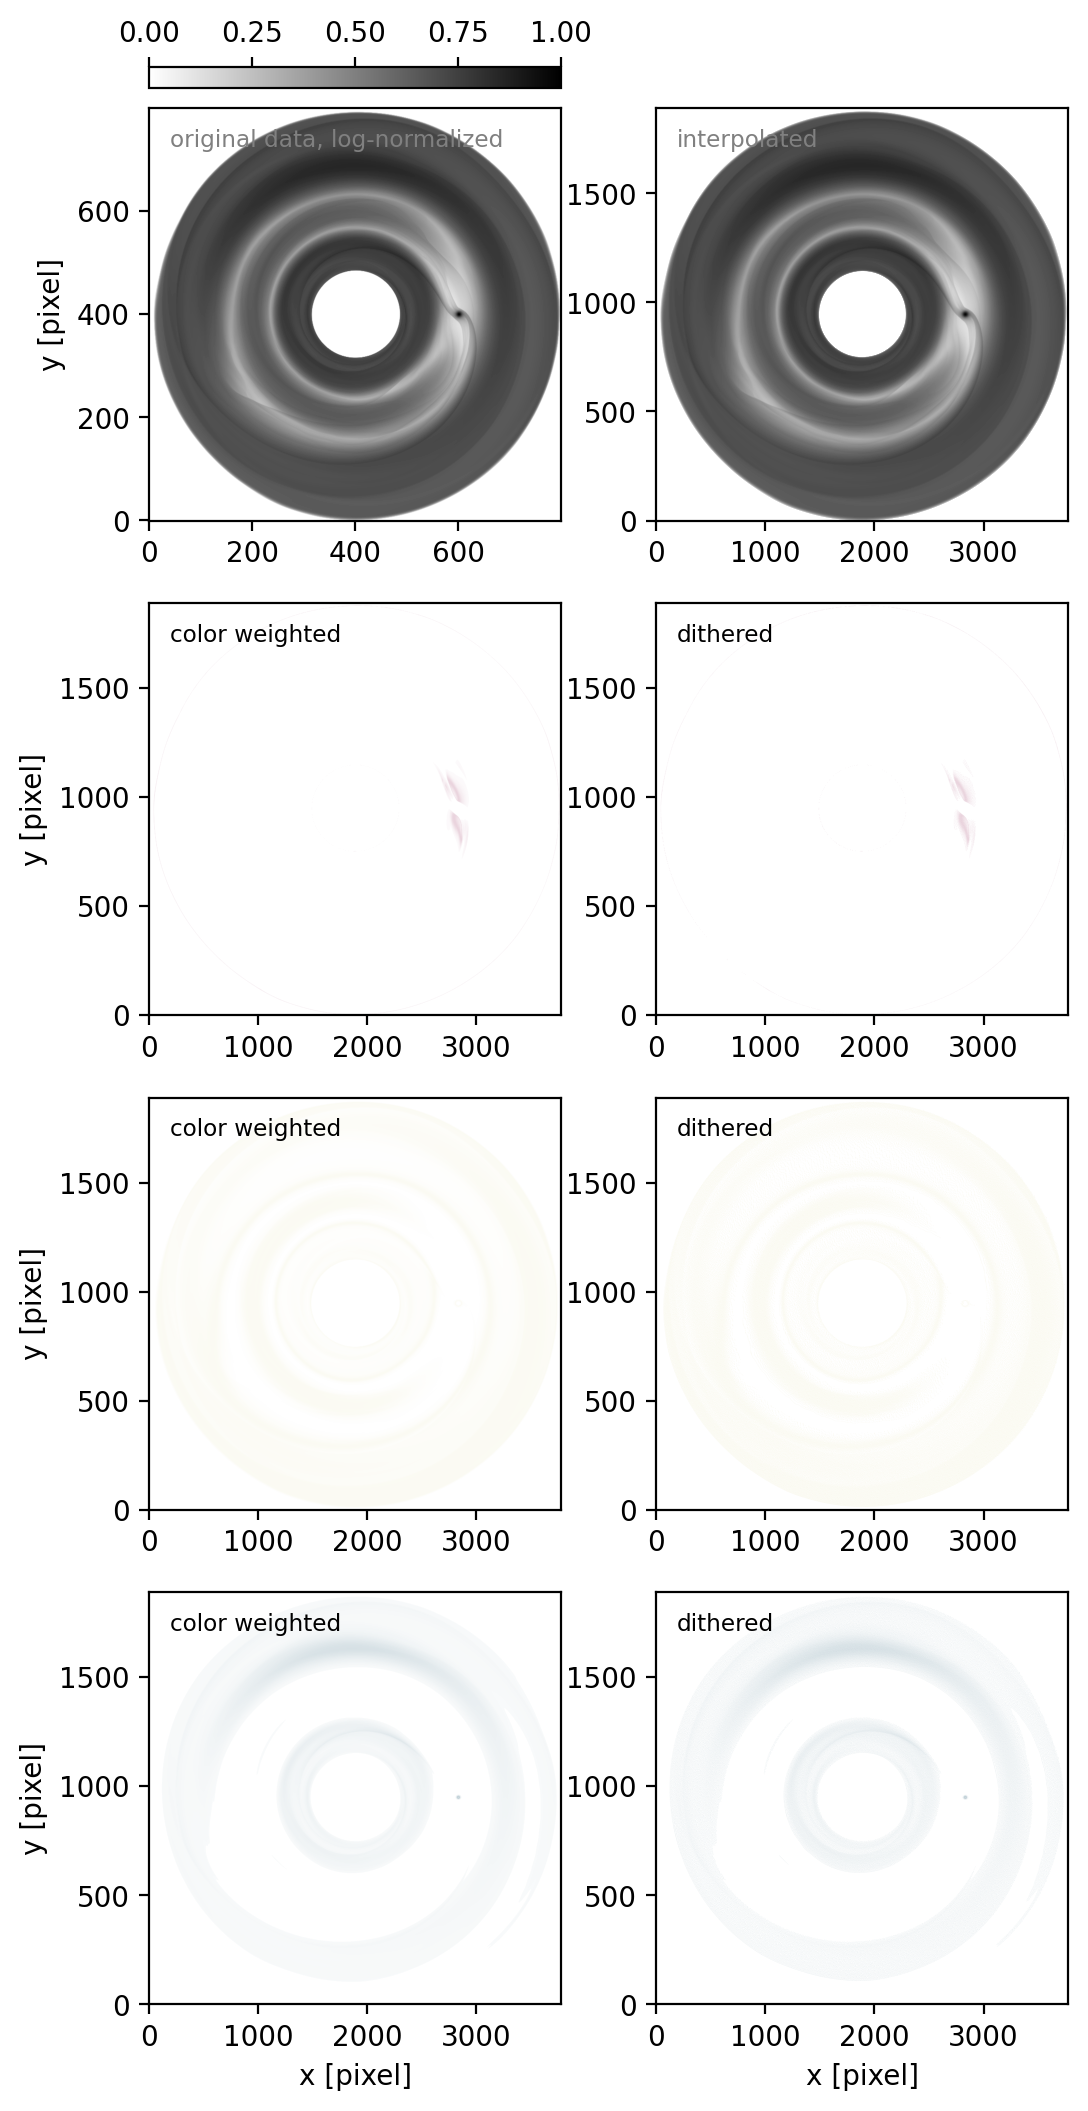

In [15]:
f, axs = plt.subplots(len(colors) + 1, 2, dpi=100, figsize=(6, 3 * (len(colors) + 1)), gridspec_kw={'top':0.9})
f.subplots_adjust(top=0.9)

# get original data near the desired position
iz0 = z.searchsorted(z2[iz])

cc=axs[0,0].imshow(norm(data[:,:,iz0]).T, vmin=0, vmax=1, origin='lower')
axs[0,0].text(0.05, 0.95, 'original data, log-normalized', c='0.5', fontsize='small', transform=axs[0,0].transAxes, va='top')

pos = axs[0,0].get_position()
cba = f.add_axes([pos.x0, pos.y1 + pos.height / 20, pos.width, pos.height / 20])
cb = f.colorbar(cc, cax=cba, orientation='horizontal')
cba.xaxis.tick_top()


# interpolate on new coordinates
_x, _y = np.meshgrid(x2, y2, indexing='ij')
_c = np.array([_x.ravel(), _y.ravel(), np.zeros_like(_x.ravel()) + z2[iz]]).T
d = f_interp(_c).reshape(len(x2), len(y2)).T

axs[0,1].imshow(d, origin='lower', norm=norm)
axs[0,1].text(0.05, 0.95, 'interpolated', fontsize='small', c='0.5', transform=axs[0,1].transAxes, va='top')

# color weightening
dist_sq = (norm(d.ravel()).reshape(d.shape)[..., None] - levels[None,None,:])**2 / (2 * sigmas[None, None, :]**2)
dist_sq[d==0] = np.inf
dist_sq[dist_sq  >clip**2] = np.inf
col_dens = 1. / (1. + dist_sq) * fill

# dithering
d2 = astro3d.fmodule.dither_colors(col_dens)


for ic, col in enumerate(colors):
    
    # cmap = sns.light_palette(col, as_cmap=True)
    cmap = LinearSegmentedColormap.from_list('my', [[1,1,1], col])
    
    axs[1+ic,0].imshow(col_dens[:, :, ic], origin='lower', vmin=0, vmax=1, cmap=cmap)
    axs[1+ic,0].text(0.05, 0.95, 'color weighted', fontsize='small', transform=axs[1+ic,0].transAxes, va='top')

    axs[1+ic,1].imshow(d2[:, :, ic], origin='lower', vmin=0, vmax=1, cmap=cmap)
    axs[1+ic,1].text(0.05, 0.95, 'dithered', fontsize='small', transform=axs[1+ic,1].transAxes, va='top');

# plot tunining


for ax in axs[:,0].ravel():
    ax.set_ylabel('y [pixel]');
for ax in axs[-1,:].ravel():
    ax.set_xlabel('x [pixel]');
    
for ax in axs.ravel()[1:]:
    ax.set_aspect(dpi_x / dpi_y)

## Iteration

In [16]:
iz = [0]  # Here we just want to print the first slice
# iz = np.arange(n_z)  # this would print all

In [17]:
for _iz in tqdm(iz):
    makeslice(_iz, z2, f_interp, coords, norm, path,
                    levels=levels, sigmas=sigmas, fill=fill,
                    colors=colors, f=np.ones(3), bg=0.7)

  0%|          | 0/1 [00:00<?, ?it/s]